In [1]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Lars Buitinck <L.J.Buitinck@uva.nl>
# License: BSD 3 clause

from __future__ import print_function

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np


# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


In [2]:
# parse commandline arguments
op = OptionParser()
op.add_option("--lsa",
              dest="n_components", type="int",
              help="Preprocess documents with latent semantic analysis.")
op.add_option("--no-minibatch",
              action="store_false", dest="minibatch", default=True,
              help="Use ordinary k-means algorithm (in batch mode).")
op.add_option("--no-idf",
              action="store_false", dest="use_idf", default=True,
              help="Disable Inverse Document Frequency feature weighting.")
op.add_option("--use-hashing",
              action="store_true", default=False,
              help="Use a hashing feature vectorizer")
op.add_option("--n-features", type=int, default=10000,
              help="Maximum number of features (dimensions)"
                   " to extract from text.")
op.add_option("--verbose",
              action="store_true", dest="verbose", default=False,
              help="Print progress reports inside k-means algorithm.")

print(__doc__)
op.print_help()

(opts, args) = op.parse_args()
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)




Automatically created module for IPython interactive environment
Usage: __main__.py [options]

Options:
  -h, --help            show this help message and exit
  --lsa=N_COMPONENTS    Preprocess documents with latent semantic analysis.
  --no-minibatch        Use ordinary k-means algorithm (in batch mode).
  --no-idf              Disable Inverse Document Frequency feature weighting.
  --use-hashing         Use a hashing feature vectorizer
  --n-features=N_FEATURES
                        Maximum number of features (dimensions) to extract
                        from text.
  --verbose             Print progress reports inside k-means algorithm.


Usage: __main__.py [options]

__main__.py: error: no such option: -f


SystemExit: 2

To exit: use 'exit', 'quit', or Ctrl-D.


In [3]:
###############################################################################
# Load some categories from the training set
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
# Uncomment the following to do the analysis on all the categories
#categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)




Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']


In [4]:
from sklearn.datasets import load_files

In [6]:
#dataset = fetch_20newsgroups(subset='all', categories=categories,
#                             shuffle=True, random_state=42,download_if_missing = False)
dataset = load_files('/home/kesj/scikit_learn_data/20news_home/20news-bydate-train/', categories=categories,
                     shuffle=True, random_state=42,encoding='ISO-8859-1') # input is not utf-8 compliant

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))
print()


2034 documents
4 categories



In [8]:
n_features = 10000

use_idf = True

In [22]:
labels = dataset.target
true_k = np.unique(labels).shape[0]

print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()
"""if opts.use_hashing:
    if opts.use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(n_features=opts.n_features,
                                   stop_words='english', non_negative=True,
                                   norm=None, binary=False)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features=opts.n_features,
                                       stop_words='english',
                                       non_negative=False, norm='l2',
                                       binary=False)
else:
"""
vectorizer = TfidfVectorizer(max_df=0.5, max_features=n_features,
                                 min_df=2, stop_words='english',
                                 use_idf=use_idf)

X = vectorizer.fit_transform(dataset.data)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()


Extracting features from the training dataset using a sparse vectorizer
done in 0.882731s
n_samples: 2034, n_features: 10000



In [21]:
true_k

4

In [23]:
n_components= 100

In [24]:

if n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    Xlsa = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()



Performing dimensionality reduction using LSA
done in 0.623237s
Explained variance of the SVD step: 27%



In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

<Container object of 100 artists>

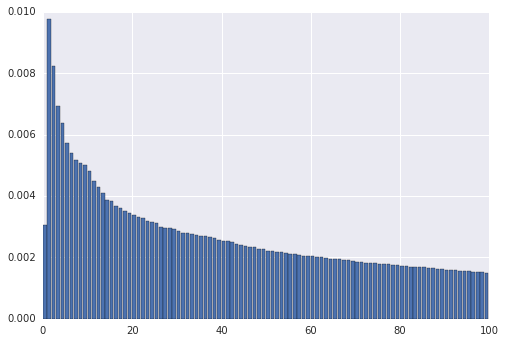

In [29]:
plt.bar(np.arange(0,len(svd.explained_variance_ratio_)),svd.explained_variance_ratio_)

In [30]:
minibatch = 0
use_hashing=False
###############################################################################
# Do the actual clustering

if minibatch:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=True)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=True)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(Xlsa)
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(Xlsa, km.labels_, sample_size=1000))

print()


if not use_hashing:
    print("Top terms per cluster:")

    if n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

Clustering sparse data with KMeans(copy_x=True, init='k-means++', max_iter=100, n_clusters=4, n_init=1,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=True)
Initialization complete
Iteration  0, inertia 3222.438
Iteration  1, inertia 1784.843
Iteration  2, inertia 1752.376
Iteration  3, inertia 1742.502
Iteration  4, inertia 1739.737
Iteration  5, inertia 1738.601
Iteration  6, inertia 1738.107
Iteration  7, inertia 1737.744
Iteration  8, inertia 1737.586
Iteration  9, inertia 1737.486
Iteration 10, inertia 1737.262
Iteration 11, inertia 1737.045
Iteration 12, inertia 1736.675
Iteration 13, inertia 1736.034
Iteration 14, inertia 1735.430
Iteration 15, inertia 1735.133
Iteration 16, inertia 1734.966
Iteration 17, inertia 1734.623
Iteration 18, inertia 1733.887
Iteration 19, inertia 1733.639
Iteration 20, inertia 1733.534
Iteration 21, inertia 1733.519
Converged at iteration 21
done in 0.054s

Homogeneity: 0.678
Completeness: 0.724
V-measure: 0.700


In [31]:
minibatch = 1
use_hashing=False
###############################################################################
# Do the actual clustering

if minibatch:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=True)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=True)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(Xlsa)
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(Xlsa, km.labels_, sample_size=1000))

print()


if not use_hashing:
    print("Top terms per cluster:")

    if n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=4,
        n_init=1, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=True)
Init 1/1 with method: k-means++
Inertia for init 1/1: 873.970866
Minibatch iteration 1/300: mean batch inertia: 0.880721, ewa inertia: 0.880721 
Minibatch iteration 2/300: mean batch inertia: 0.867977, ewa inertia: 0.868196 
Minibatch iteration 3/300: mean batch inertia: 0.862499, ewa inertia: 0.862597 
Minibatch iteration 4/300: mean batch inertia: 0.861945, ewa inertia: 0.861957 
Minibatch iteration 5/300: mean batch inertia: 0.862798, ewa inertia: 0.862783 
Minibatch iteration 6/300: mean batch inertia: 0.858739, ewa inertia: 0.858809 
Minibatch iteration 7/300: mean batch inertia: 0.865467, ewa inertia: 0.865353 
Minibatch iteration 8/300: mean batch inertia: 0.858589, ewa inertia: 0.858705 
Minibatch iteration 9/300: 

In [17]:
X.shape

(2034, 20)

In [18]:
X[:1]

array([[ 0.47613781,  0.29199845, -0.01392281, -0.43450938,  0.42529957,
         0.42043609,  0.05475372,  0.06471751, -0.02797768, -0.0390973 ,
        -0.00686906, -0.12182542,  0.01862731,  0.0410083 , -0.14024352,
         0.15225497,  0.14242073,  0.16323901, -0.12616133, -0.09632821]])

In [19]:
print(len(dataset))

5
